<a href="https://colab.research.google.com/github/SHA152/time_series_forecasting_SARIMA/blob/main/Dreampress_ARIMA%2C_SARIMA_and_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Useful Functions

In [1]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Plot training, test, and forecasts
  plt.figure(figsize = (10,4))
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = mean_squared_error(test, predictions, squared = False)
  mape = mean_absolute_percentage_error(test, predictions)

  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")


In [2]:
# Function to assess model and visualize output
def model_prediction_graph(train, test, predictions, chart_title):
  # Plot training, test, and forecasts
  plt.figure(figsize = (10,4))
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

In [3]:
# Function to plot the future
def plot_future(y, forecast, title):
  # Plot training and forecasts
  plt.figure(figsize = (10,4))
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

# Libraries and Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/ARIMA, SARIMA and SARIMAX

/content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/ARIMA, SARIMA and SARIMAX


In [6]:
# Libraries
!pip install pmdarima
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid
from pmdarima.arima import auto_arima, ARIMA
from pmdarima import model_selection # Import model_selection directly from pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.2 MB/s eta 0:00:00


In [7]:
# Loading the Data and Setting the Index
df = pd.read_csv("DreamPress.csv", index_col = "Month", parse_dates = True, dayfirst=True)
df.head()

<ipython-input-7-8c6eb52bf2bb>:2: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df = pd.read_csv("DreamPress.csv", index_col = "Month", parse_dates = True, dayfirst=True)


,adds
Month,
2017-12-31,508
2018-01-31,602
2018-02-28,608
2018-03-31,672
2018-04-30,464


In [8]:
# Information about the df
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81 entries, 2017-12-31 to 2024-08-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   adds    81 non-null     object
dtypes: object(1)
memory usage: 1.3+ KB


In [9]:
# Setting the Frequency
df = df.asfreq("M")

In [10]:
# Change the time Series variable name
df = df.rename(columns = {'adds': 'y'})
df.head()

,y
Month,
2017-12-31,508
2018-01-31,602
2018-02-28,608
2018-03-31,672
2018-04-30,464


In [11]:
# Transform revenue into a float and assign it back to the column
# Check if the column is of type object (string) before applying str methods
if df['y'].dtype == object:
    df['y'] = df['y'].str.replace(",","").astype(float)
else:
    print("Column 'y' is already numeric. Skipping string conversion.")

# Exploratory Data Analysis

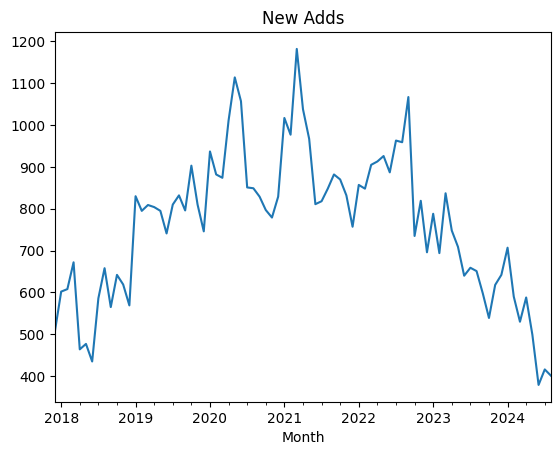

In [12]:
# Daily Closing Price  Plot
df['y'].plot(title = 'New Adds')
plt.show()

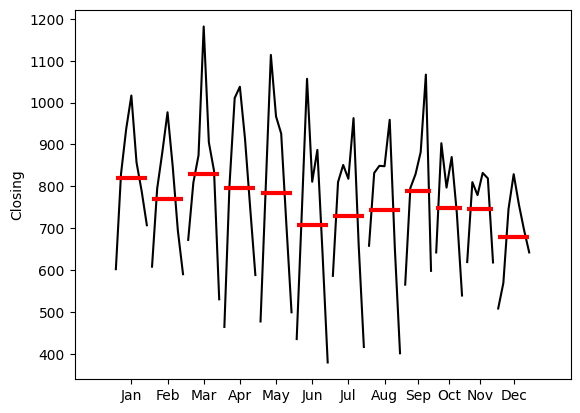

In [13]:
# Plotting the monthly seasonality
month_plot(df['y'].resample('M').mean(),
           ylabel = 'Closing')
plt.show()

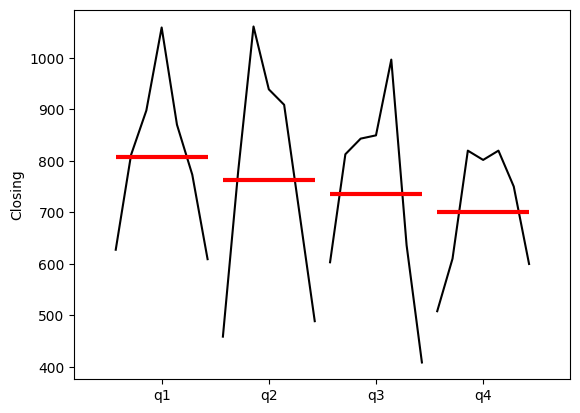

In [14]:
# Plotting the quarterly seasonality
quarter_plot(df['y'].resample('Q').mean(),
           ylabel = 'Closing')
plt.show()

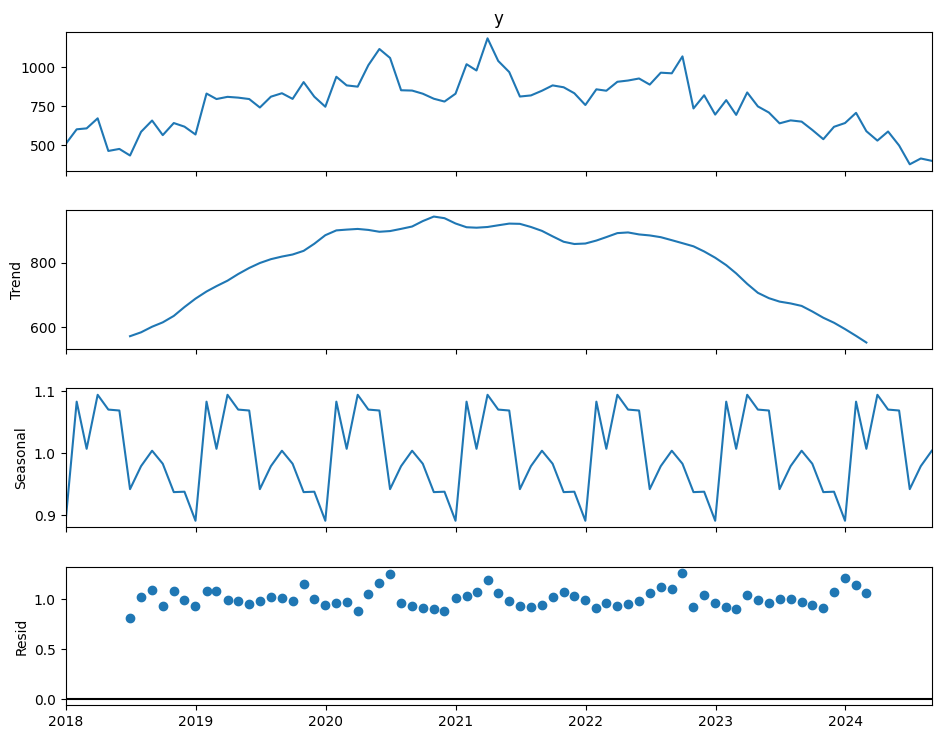

In [15]:
# Seasonal Decomposition Plots
decomposition = seasonal_decompose(df['y'],
                                   model = 'mul',
                                   period = 12)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

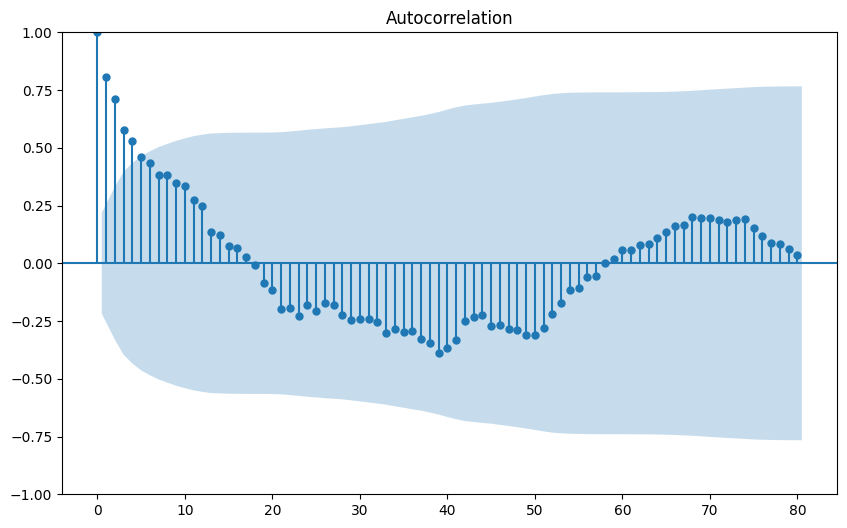

In [16]:
# Plot the autocorrelation (ACF)
fig, ax = plt.subplots(figsize = (10,6))
# Set lags to be less than or equal to the length of the DataFrame
plot_acf(df['y'], lags = len(df) -1 , ax = ax)
plt.show()

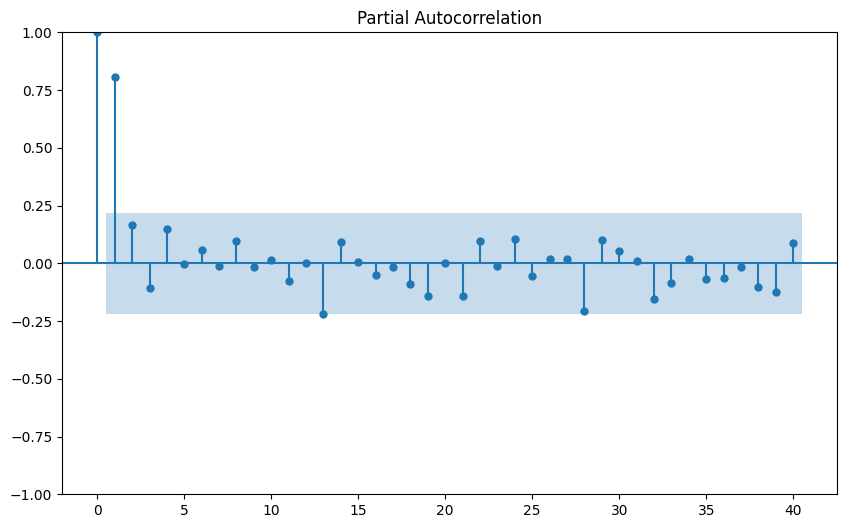

In [17]:
# Plot the partial autocorrelation (PACF)
fig, ax = plt.subplots(figsize = (10,6))
# Calculate maximum lag based on 50% of data length
max_lag = len(df) // 2  # Use floor division to ensure integer result
# Use min to select the smaller value between max_lag and original lags
plot_pacf(df['y'], lags = min(100, max_lag), ax = ax)
plt.show()

# Checking Stationarity

In [18]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test on the 'y' column of the DataFrame
adf_test_result = adfuller(df['y'])

# Extract the test statistic, p-value, used lags, and number of observations
adf_statistic = adf_test_result[0]
p_value = adf_test_result[1]
used_lag = adf_test_result[2]
n_obs = adf_test_result[3]
critical_values = adf_test_result[4]  # Critical values for different significance levels

# Print the results
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print(f'Number of Lags Used: {used_lag}')
print(f'Number of Observations Used: {n_obs}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

# Interpretation of the ADF test results
if p_value < 0.05:
    print("The time series is stationary. Reject the null hypothesis (H0).")
else:
    print("The time series is non-stationary. Fail to reject the null hypothesis (H0).")

ADF Statistic: -1.5493957935465783
p-value: 0.5089499910314891
Number of Lags Used: 1
Number of Observations Used: 79
Critical Values:
   1%: -3.5159766913976376
   5%: -2.898885703483903
   10%: -2.5866935058484217
The time series is non-stationary. Fail to reject the null hypothesis (H0).


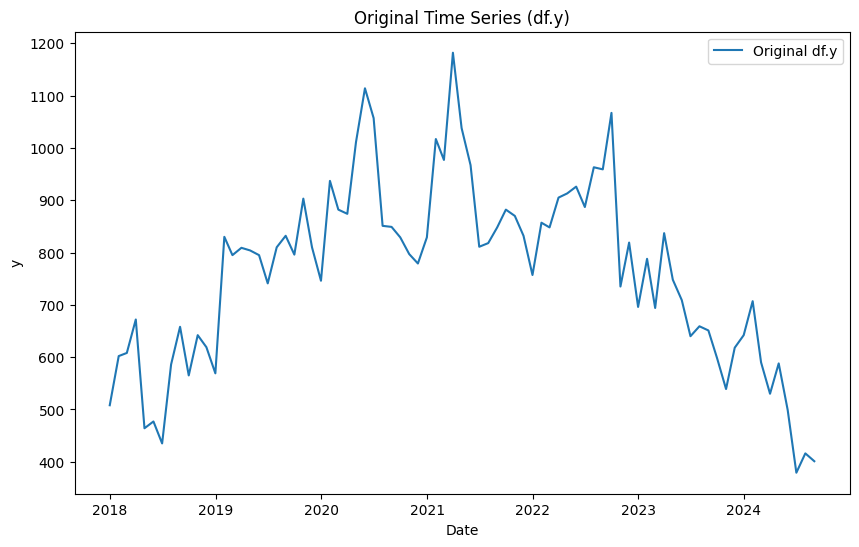

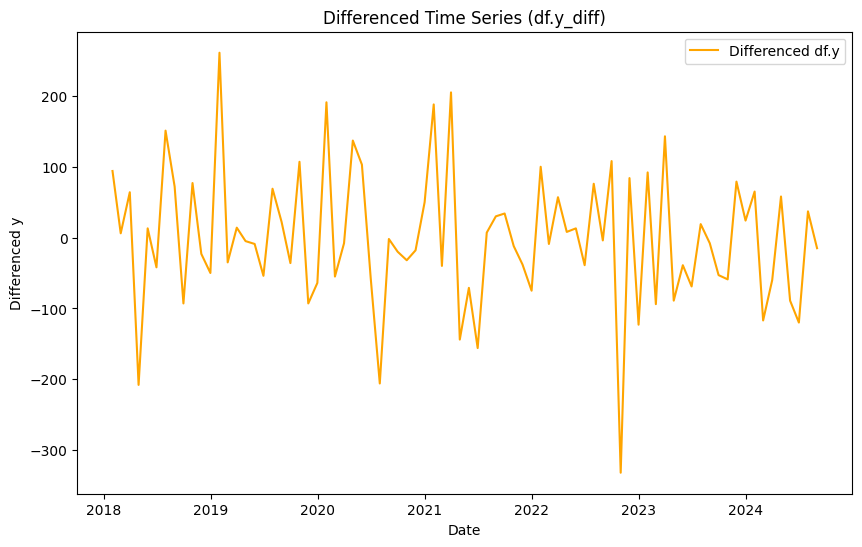

In [19]:
# Doing the first differencing

# Plot the original time series
plt.figure(figsize=(10, 6))
plt.plot(df['y'], label='Original df.y')
plt.title('Original Time Series (df.y)')
plt.xlabel('Date')
plt.ylabel('y')
plt.legend()
plt.show()

# Apply first differencing to make the time series stationary
df['y_diff'] = df['y'].diff().dropna()

# Plot the differenced time series
plt.figure(figsize=(10, 6))
plt.plot(df['y_diff'], label='Differenced df.y', color='orange')
plt.title('Differenced Time Series (df.y_diff)')
plt.xlabel('Date')
plt.ylabel('Differenced y')
plt.legend()
plt.show()



In [20]:
# Perform the Augmented Dickey-Fuller test on the 'y' column of the DataFrame
adf_test_result = adfuller(df['y_diff'].dropna())

# Extract the test statistic, p-value, used lags, and number of observations
adf_statistic = adf_test_result[0]
p_value = adf_test_result[1]
used_lag = adf_test_result[2]
n_obs = adf_test_result[3]
critical_values = adf_test_result[4]  # Critical values for different significance levels

# Print the results
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print(f'Number of Lags Used: {used_lag}')
print(f'Number of Observations Used: {n_obs}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

# Interpretation of the ADF test results
if p_value < 0.05:
    print("The time series is stationary. Reject the null hypothesis (H0).")
else:
    print("The time series is non-stationary. Fail to reject the null hypothesis (H0).")

ADF Statistic: -11.677601777809036
p-value: 1.7727073771986147e-21
Number of Lags Used: 0
Number of Observations Used: 79
Critical Values:
   1%: -3.5159766913976376
   5%: -2.898885703483903
   10%: -2.5866935058484217
The time series is stationary. Reject the null hypothesis (H0).


# SARIMA Model

In [21]:
# Split the Data into training and test
test_months = 12
train, test = df.iloc[:-test_months], df.iloc[-test_months:]
test


,y,y_diff
Month,,
2023-09-30,598.0,-53.0
2023-10-31,539.0,-59.0
2023-11-30,618.0,79.0
2023-12-31,642.0,24.0
2024-01-31,707.0,65.0
2024-02-29,590.0,-117.0
2024-03-31,530.0,-60.0
2024-04-30,588.0,58.0
2024-05-31,499.0,-89.0


# SARIMA

In [35]:
# Assuming 'train' is your DataFrame with a 'y' column containing the time series data

# Run auto_arima to find the best SARIMA parameters for monthly data
model_SARIMA = auto_arima(train['y'],
                           m=12,  # Set seasonality to 12 for monthly data
                           seasonal=True,
                           start_p=0, start_q=0, max_p=5, max_q=5,
                           start_P=0, start_Q=0, max_P=5, max_Q=5,
                           d=None, D=None,
                           trace=True,
                           error_action='ignore', suppress_warnings=True, stepwise=True)

# Print the model summary
model_SARIMA.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=823.415, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=816.896, Time=1.76 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=817.989, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=821.445, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=819.263, Time=0.21 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=818.063, Time=4.75 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=817.790, Time=2.49 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=817.881, Time=0.59 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.83 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=818.975, Time=0.59 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=818.829, Time=0.52 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=817.839, Time=0.83 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=816.893, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=819.530, Time=0.15 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   69
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                -404.448
Date:                             Fri, 27 Sep 2024   AIC                            814.895
Time:                                     16:51:55   BIC                            821.554
Sample:                                 12-31-2017   HQIC                           817.533
                                      - 08-31-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2641      0.131     -2.017      0.044      -0.521      -0.007
ar.S.L12       0.2943      0.156      1.892      0.058      -0.011       0.599
sigma2      8436.3659   1210.942      6.967      0.000    6062.963    1.08e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 6.46
Prob(Q):                              0.92   Prob(JB):                         0.04
Heteroskedasticity (H):               1.09   Skew:                            -0.42
Prob(H) (two-sided):                  0.84   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
# Assuming 'model_SARIMA' is the fitted SARIMA model
# Get predictions
predictions_sarima = model_SARIMA.predict(n_periods=test_months)

# # Optionally, if you need the predictions as a pandas Series with the correct index:
# predictions_sarima = pd.Series(predictions_sarima, index=test.index)  # Assuming 'test' is your test DataFrame

# Display the predictions
print(predictions_sarima)


2023-09-30    686.175090
2023-10-31    588.455106
2023-11-30    613.179439
2023-12-31    576.975951
2024-01-31    604.054983
2024-02-29    576.387276
2024-03-31    618.477511
2024-04-30    592.281491
2024-05-31    580.802336
2024-06-30    560.493062
2024-07-31    566.085471
2024-08-31    563.730772
Freq: M, dtype: float64


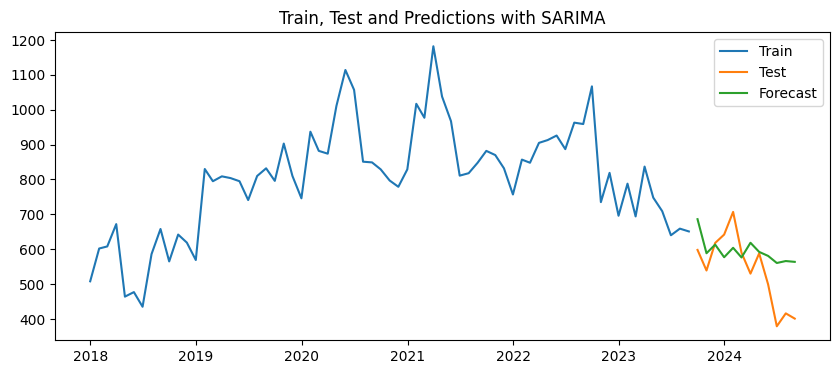

The MAE is 82.74
The RMSE is 100.72
The MAPE is 17.50 %


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [37]:
# Model Assessment
model_assessment(train['y'], test['y'], predictions_sarima, "SARIMA")

In [38]:
# Assuming 'test_months' is the number of periods you want to predict
# And 'model_SARIMA' is your fitted SARIMA model
SARIMA_Model_DreamPress = ARIMA(order=(0, 1, 1), seasonal_order=(1, 0, 0, 12), suppress_warnings=True)
SARIMA_Model_DreamPress = SARIMA_Model_DreamPress.fit(train['y'])  # Fit the model to the training data

# Get predictions using the 'predict' method
predictions_sarima_DreamPress = SARIMA_Model_DreamPress.predict(n_periods=48)

# Optionally, if you need the predictions as a pandas Series with the correct index:
# predictions_sarima = pd.Series(predictions_sarima_VPS, index=pd.date_range(start=train.index[-1], periods=48, freq='MS'))  # Assuming 'test' is your test DataFrame and your data is monthly

# Display the predictions
print(predictions_sarima_DreamPress)


2023-09-30    686.650755
2023-10-31    589.489552
2023-11-30    614.560153
2023-12-31    578.808678
2024-01-31    606.229891
2024-02-29    578.999383
2024-03-31    621.405745
2024-04-30    595.644370
2024-05-31    584.574317
2024-06-30    564.689471
2024-07-31    570.661353
2024-08-31    568.699920
2024-09-30    579.564234
2024-10-31    551.404882
2024-11-30    559.160467
2024-12-31    549.044917
2025-01-31    557.491173
2025-02-28    549.879309
2025-03-31    562.728599
2025-04-30    555.548404
2025-05-31    552.684909
2025-06-30    547.231394
2025-07-31    549.375270
2025-08-31    549.188129
2025-09-30    552.769530
2025-10-31    544.884747
2025-11-30    547.552722
2025-12-31    544.969685
2026-01-31    547.840598
2026-02-28    545.993209
2026-03-31    550.157850
2026-04-30    548.437298
2026-05-31    547.985106
2026-06-30    546.771898
2026-07-31    547.791005
2026-08-31    548.125197
2026-09-30    549.566686
2026-10-31    547.639107
2026-11-30    548.812208
2026-12-31    548.442423


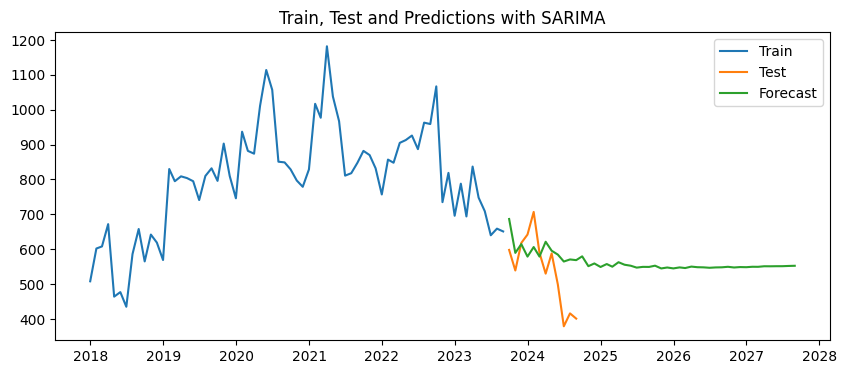

In [40]:
# Model Assessment
model_prediction_graph(train['y'], test['y'], predictions_sarima_DreamPress, "SARIMA") # This is a function defined at the begining of the file along with some other "Useful Functions"